In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [3]:
# Fungsi untuk membaca gambar dari folder
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for class_label in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_label)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                try:
                    # Membaca gambar dalam grayscale
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    # Resize gambar menjadi 48x48 sesuai dataset FER-2013
                    image = cv2.resize(image, (48, 48))
                    images.append(image.flatten())
                    labels.append(class_label)
                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")
    return np.array(images), np.array(labels)

# Load dataset
train_path = "dataset/train"
test_path = "dataset/test"

X_train, y_train = load_images_from_folder(train_path)
X_test, y_test = load_images_from_folder(test_path)

# Normalisasi
X_train = X_train / 255.0
X_test = X_test / 255.0

# Encode label
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# PCA untuk reduksi dimensi
pca = PCA(n_components=100)  # Mengurangi ke 100 dimensi
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [4]:
# Model SVM dengan Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['rbf']
}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=3)
grid.fit(X_train_pca, y_train)

# Evaluasi Model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_pca)

print("Best Parameters:", grid.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  56.5s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  40.1s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=  39.7s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  44.5s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  39.8s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  42.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  43.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  41.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  41.2s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=  33.3s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=  33.8s
[CV] END .......................C=1, gamma=0.001,

Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

       angry       0.35      0.36      0.35       958
     disgust       0.78      0.53      0.63       111
        fear       0.40      0.38      0.39      1024
       happy       0.58      0.65      0.61      1774
     neutral       0.43      0.45      0.44      1233
         sad       0.39      0.35      0.37      1247
    surprise       0.71      0.63      0.67       831

    accuracy                           0.48      7178
   macro avg       0.52      0.48      0.49      7178
weighted avg       0.48      0.48      0.48      7178



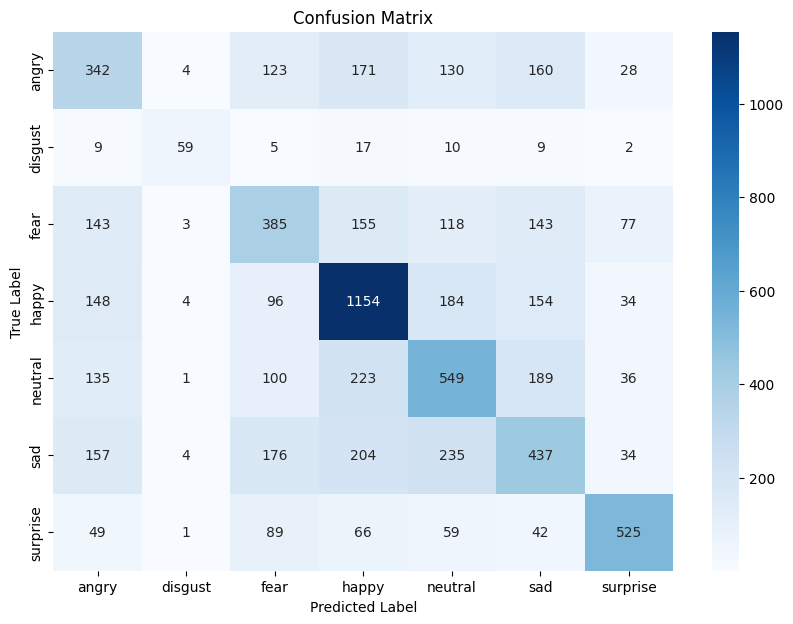

angry:
  precision: 0.35
  recall: 0.36
  f1-score: 0.35
  support: 958.00
disgust:
  precision: 0.78
  recall: 0.53
  f1-score: 0.63
  support: 111.00
fear:
  precision: 0.40
  recall: 0.38
  f1-score: 0.39
  support: 1024.00
happy:
  precision: 0.58
  recall: 0.65
  f1-score: 0.61
  support: 1774.00
neutral:
  precision: 0.43
  recall: 0.45
  f1-score: 0.44
  support: 1233.00
sad:
  precision: 0.39
  recall: 0.35
  f1-score: 0.37
  support: 1247.00
surprise:
  precision: 0.71
  recall: 0.63
  f1-score: 0.67
  support: 831.00
accuracy: 0.48
macro avg:
  precision: 0.52
  recall: 0.48
  f1-score: 0.49
  support: 7178.00
weighted avg:
  precision: 0.48
  recall: 0.48
  f1-score: 0.48
  support: 7178.00


In [7]:
import seaborn as sns
# Evaluasi Model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_pca)

print("Best Parameters:", grid.best_params_)
print("Classification Report:")
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasi Confusion Matrix dengan angka
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Overall Metrics
for metric, value in report.items():
    if isinstance(value, dict):  # Untuk setiap kelas
        print(f"{metric}:")
        for sub_metric, sub_value in value.items():
            print(f"  {sub_metric}: {sub_value:.2f}")
    else:
        print(f"{metric}: {value:.2f}")